In [1]:
%matplotlib inline


Metrics to judge the sucess of a model
=======================================

Pro & cons of various performance metrics.

The simple way to use a scoring metric during cross-validation is
via the `scoring` parameter of
:func:`sklearn.model_selection.cross_val_score`.



Regression settings
-----------------------

The Boston housing data
........................



In [2]:
from sklearn import datasets
boston = datasets.load_boston()

# Shuffle the data
from sklearn.utils import shuffle
data, target = shuffle(boston.data, boston.target, random_state=0)

A quick plot of how each feature is related to the target



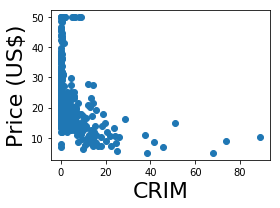

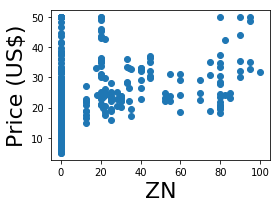

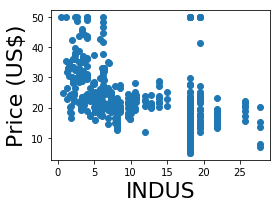

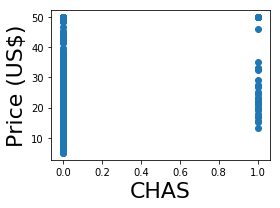

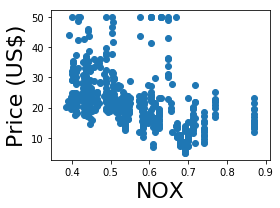

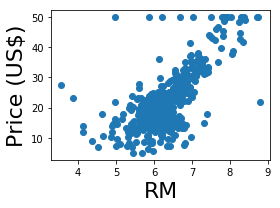

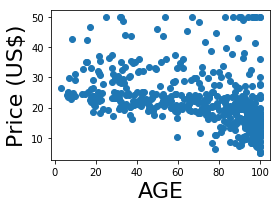

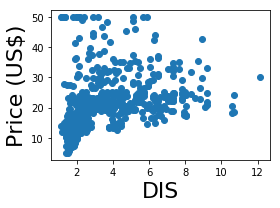

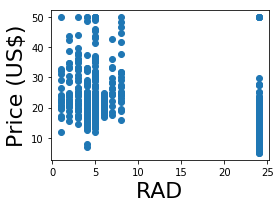

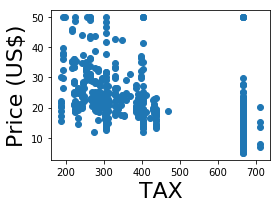

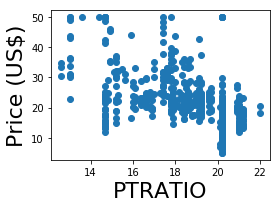

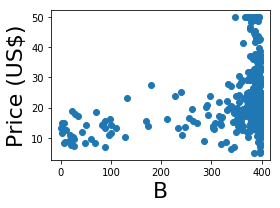

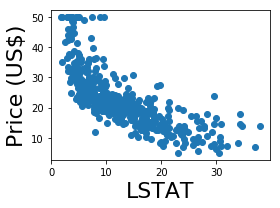

In [3]:
from matplotlib import pyplot as plt

for feature, name in zip(data.T, boston.feature_names):
    plt.figure(figsize=(4, 3))
    plt.scatter(feature, target)
    plt.xlabel(name, size=22)
    plt.ylabel('Price (US$)', size=22)
    plt.tight_layout()

We will be using a random forest regressor to predict the price



In [4]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()

Explained variance vs Mean Square Error
.......................................

The default score is explained variance



In [5]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(regressor, data, target))

[ 0.82009948  0.84057488  0.81186577]


Explained variance is convienent because it has a natural scaling: 1 is
perfect prediction, and 0 is around chance

Now let us see which houses are easier to predict:

Not along the Charles river (feature 3)



In [6]:
print(cross_val_score(regressor, data[data[:, 3] == 0],
                      target[data[:, 3] == 0]))

[ 0.81175361  0.90426463  0.82889878]


Along the Charles river



In [7]:
print(cross_val_score(regressor, data[data[:, 3] == 1],
                      target[data[:, 3] == 1]))

[ 0.54060899  0.04374885  0.56666682]


So the houses along the Charles are harder to predict?

It is not so easy to conclude this from the explained variance: in two
different sets of observations, the variance of the target differs, and
the explained variance is a relative measure

**MSE**: We can use the mean squared error (here negated)

Not along the Charles river



In [8]:
print(cross_val_score(regressor, data[data[:, 3] == 0],
                      target[data[:, 3] == 0],
                      scoring='neg_mean_squared_error'))

[-12.9402293   -8.3217121  -12.33394777]


Along the Charles river



In [9]:
print(cross_val_score(regressor, data[data[:, 3] == 1],
                      target[data[:, 3] == 1],
                      scoring='neg_mean_squared_error'))

[-75.615025   -51.92325833 -35.64407273]


So the error is larger along the Charles river



Mean Squared Error versus Mean Absolute Error
..................................................

What if we want to report an error in dollars, meaningful for an
application?

The Mean Absolute Error is useful for this goal



In [10]:
print(cross_val_score(regressor, data, target,
                      scoring='neg_mean_absolute_error'))

[-2.57260355 -2.25236686 -2.71035714]


Summary
.........

* **explained variance**: scaled with regards to chance: 1 = perfect,
  0 = around chance, but it shouldn't used to compare predictions
  across datasets

* **mean absolute error**: enables comparison across datasets in the
  units of the target



Classification settings
-----------------------

The digits data
.................



In [11]:
digits = datasets.load_digits()
# Let us try to detect sevens:
sevens = (digits.target == 7)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

Accuracy and its shortcomings
.............................

The default metric is the accuracy: the averaged fraction of success.
It takes values between 0 and 1, where 1 is perfect prediction



In [12]:
print(cross_val_score(classifier, digits.data, sevens))

[ 0.965       0.97996661  0.99331104]


However, a stupid classifier can each good prediction wit imbalanced
classes



In [13]:
from sklearn.dummy import DummyClassifier
most_frequent = DummyClassifier(strategy='most_frequent')
print(cross_val_score(most_frequent, digits.data, sevens))

[ 0.9         0.89983306  0.90133779]


Balanced accuracy (available in scikit-learn 0.20)
fixes this, but can have surprising behaviors, such as being negative,
and can only be used for binary classification.



In [14]:
print(cross_val_score(classifier, digits.data, sevens,
                      scoring='balanced_accuracy'))

ValueError: 'balanced_accuracy' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

Precision, recall, and their shortcomings
..........................................

We can measure separately false detection and misses

**Precision**: Precision counts the ratio of detections that are
correct



In [15]:
print(cross_val_score(classifier, digits.data, sevens,
                      scoring='precision'))

[ 1.          1.          0.92727273]


Our classifier has a good precision: most of the sevens that it
predicts are really sevens.

As predicting the most frequent never predicts sevens, precision is ill
defined. Scikit-learn puts it to zero



In [16]:
print(cross_val_score(most_frequent, digits.data, sevens,
                      scoring='precision'))

[ 0.  0.  0.]


/home/varoquau/dev/scikit-learn/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Recall**: Recall counts the fraction of class 1 actually detected



In [17]:
print(cross_val_score(classifier, digits.data, sevens, scoring='recall'))

[ 0.76666667  0.91666667  0.86440678]


Our recall isn't as good: we miss many sevens

But predicting the most frequent never predicts sevens:



In [18]:
print(cross_val_score(most_frequent, digits.data, sevens, scoring='recall'))

[ 0.  0.  0.]


**Note**: Measuring only the precision without the recall makes no
sense, it is easy to maximize one at the cost of the other. Ideally,
classifiers should be compared on a precision at a given recall



Area under the ROC curve
..........................

.. figure:: ../03_figures/images/sphx_glr_roc_curve_001.png
  :align: right
  :target: ../03_figures/roc_curve.html


If the classifier provides a decision function that can be thresholded
to control false positives versus false negatives, the ROC curve
summarise the different tradeoffs that can be achieved by varying this
threshold.

Its Area Under the Curve (AUC) is a useful metric where 1 is perfect
prediction and .5 is chance, independently of class imbalance



In [19]:
print(cross_val_score(classifier, digits.data, sevens, scoring='roc_auc'))

[ 0.98615741  0.99800557  0.9886796 ]


In [20]:
print(cross_val_score(most_frequent, digits.data, sevens, scoring='roc_auc'))

[ 0.5  0.5  0.5]


Average precision
..................

When the classifier exposes its unthresholded decision, another
interesting metric is the average precision for all recall. Compared to
ROC AUC it has a more linear behavior for very rare classes. Indeed,
with very rare classes, small changes in the ROC AUC may mean large
changes in terms of precision



In [21]:
print(cross_val_score(classifier, digits.data, sevens,
                      scoring='average_precision'))

[ 0.91049456  0.97882002  0.97675883]


Naive decisions are no longer at .5



In [22]:
print(cross_val_score(most_frequent, digits.data, sevens,
                      scoring='average_precision'))

[ 0.1         0.10016694  0.09866221]


Multiclass and multilabel settings
...................................

To simplify the discussion, we have reduced the problem to detecting
sevens, but maybe it is more interesting to predict the digit: a
10-class classification problem

**Accuracy** The accuracy is naturally defined in such multiclass settings



In [23]:
print(cross_val_score(classifier, digits.data, digits.target))

[ 0.8820598   0.90651085  0.90100671]


The most frequent label is no longer a very interesting baseline



In [24]:
random_choice = DummyClassifier()
print(cross_val_score(random_choice, digits.data, digits.target))

[ 0.08637874  0.09348915  0.11073826]


Precision and recall need the notion of specific class to detect
(called positive class) and are not that easily defined in these
settings, hence ROC AUC cannot be easily computed.

These notions are however well defined in a multi-label problem.
In such a problem, the goal is to assign one or more labels to each
instance, as opposed to a multiclass. A multiclass problem can be
turned into a multilabel one, though the prediction will then be
slightly different



In [25]:
from sklearn.preprocessing import LabelBinarizer
digit_labels = LabelBinarizer().fit_transform(digits.target)
print(digit_labels[:15])

[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


The ROC AUC can then be computed for each label, and the mean is
reported



In [26]:
print(cross_val_score(classifier, digits.data, digit_labels,
                      scoring='roc_auc'))

[ 0.98237151  0.9925703   0.98404208]


as well as the average precision



In [27]:
print(cross_val_score(classifier, digits.data, digit_labels,
                      scoring='average_precision'))

[ 0.95169342  0.93823029  0.92132974]


Note that the confusion between classes may not well be captured in
Such a measure, as in multiclass predictions are exclusive, and not
in multilabel.



Summary
..........

Class imbalance and the tradeoffs between accepting many misses or many
false detections are the things to keep in mind in classification.

In single-class settings, ROC AUC and average precision give nice
summaries to compare classifiers when the threshold can be varied. In
multiclass settings, this is harder, unless we are willing to consider
the problem as multiple single-class problems (one-vs-all).

____________________

